In [1]:
import scanpy as sc
import pandas as pd
import random
import numpy as np
import anndata as ad
import seaborn as sns


In [ ]:
#Read in single cell
adata = sc.read_h5ad("SEAAD_A9_RNAseq_final-nuclei.2024-02-13.h5ad")

QC metrics - this data is already filtered of low quality cells.

In [8]:
np.max(adata.obs['Doublet score'])
adata.obs['Used in analysis'].value_counts()
np.max(adata.obs['Fraction mitochondrial UMIs'])

0.04999358952045441

In [10]:
adata.obs['Brain Region'].value_counts()

Brain Region
Human DFC_all_layers    1395601
Name: count, dtype: int64

What cell types are there?

In [11]:
adata.obs['Class'].value_counts()

Class
Neuronal: Glutamatergic        660751
Neuronal: GABAergic            422449
Non-neuronal and Non-neural    312401
Name: count, dtype: int64

UMAP

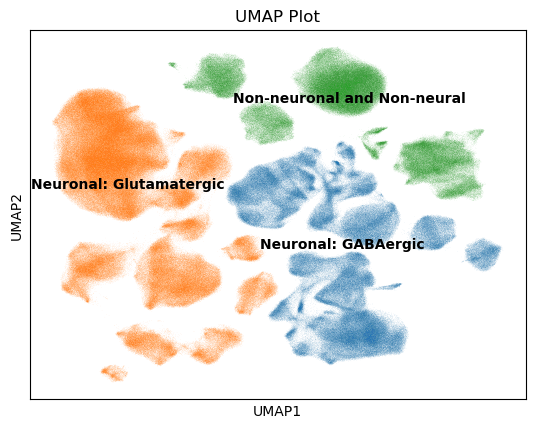

In [12]:
sc.pl.umap(adata,color = "Class", legend_loc='on data', title='UMAP Plot')

Filter out Excitatory Neurons

In [13]:
ExcNeurons =  adata[adata.obs['Class'] == 'Neuronal: Glutamatergic']
# InhNeurons = adata[adata.obs['Class'] == "Neuronal: GABAergic"]

In [14]:
del adata

How many donors?

In [15]:
ExcNeurons.obs['Donor ID'].value_counts()

Donor ID
H19.30.002    17345
H19.30.001    16625
H18.30.002    16188
H20.33.015    15816
H21.33.032    14465
              ...  
H20.33.038     4084
H21.33.045     3422
H20.33.028     3204
H21.33.034     1272
H21.33.020     1249
Name: count, Length: 83, dtype: int64

How many cells per donor?

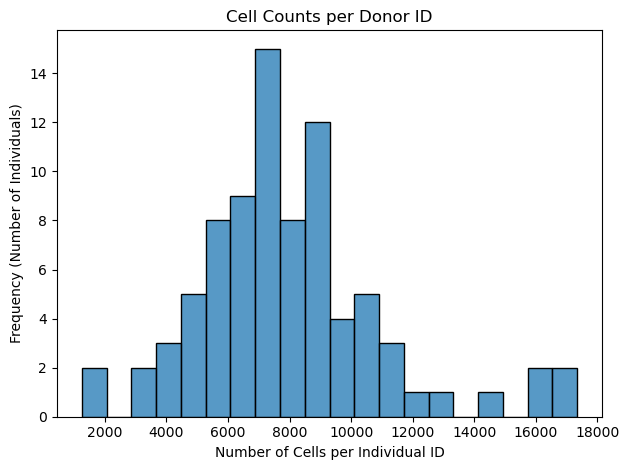

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count the number of cells for each individualID
cell_count = ExcNeurons.obs['Donor ID'].value_counts()

# Create plot
sns.histplot(cell_count, bins=20)  # Adjust bins if needed
plt.xlabel('Number of Cells per Individual ID')
plt.ylabel('Frequency (Number of Individuals)')
plt.title('Cell Counts per Donor ID')

# Adjust layout
plt.tight_layout()

#Show the plots
plt.show()

How Many genes in Exc Neurons

In [17]:
ExcNeurons.var.shape

(36601, 1)

In [ ]:
from anndata import AnnData
from scipy.sparse import csr_matrix

# Group by subjects and sum the expression counts
grouped = ExcNeurons.obs.groupby('Donor ID').indices

# Convert SparseCSRView to csr_matrix
dense_X = csr_matrix(ExcNeurons.layers['UMIs'])

# Initialize the pseudobulk matrix
pseudobulk = np.zeros((len(grouped), dense_X.shape[1]))

# Loop through subjects
for i, (subject, cell_indices) in enumerate(grouped.items()):
    # Use csr_matrix to efficiently sum across cells
    pseudobulk[i, :] = dense_X[cell_indices, :].sum(axis=0)
    print(f"Done with subject {subject}")

# df = pd.DataFrame(pseudobulk, columns=ExcNeurons.var.index, index=grouped.keys())
# df.to_csv("ExcNeurons_pseudobulk_method1.csv")


In [ ]:
# Create a new AnnData object for pseudobulk samples
pseudobulk_adata = AnnData(X=csr_matrix(pseudobulk))
pseudobulk_adata.obs['DonorID'] = list(grouped.keys()) #give subjects names to adata
pseudobulk_adata.var = ExcNeurons.var #give gene symbols to new adata
# Print the shape of the pseudobulk samples
print("Pseudobulk samples shape:", pseudobulk_adata.X.shape)

# Display the pseudobulk data
print("Pseudobulk data:")
print(pseudobulk_adata.X)

In [ ]:
#Optionally, filter genes with a minimum total count across all cells
num_samples = pseudobulk_adata.shape[0]
threshold = int(0.7 * num_samples)
print(f"Filtering genes with expression in at least {threshold} samples")
sc.pp.filter_genes(pseudobulk_adata, min_cells=threshold)

print(pseudobulk_adata.X.shape)


In [ ]:
# Convert adata.X to a DataFrame, using adata.obs['individualID'] as index and adata.var as column names
df = pd.DataFrame(pseudobulk_adata.X.toarray(), 
                  index=pseudobulk_adata.obs['DonorID'],
                  columns=pseudobulk_adata.var_names)

In [ ]:
# Write DataFrame to a CSV file
df.to_csv("seattle_ad_pseudobulk_matrix_A9.csv", index=True)

Put Metadata in a df, save

In [ ]:
# Initialize a list to store metadata for each subject
metadata_list = []

for subject in grouped.keys():
    #The adata subset, all cells matching 'subject' donor ID
    subj_cell_subset = ExcNeurons[ExcNeurons.obs['Donor ID'] == subject]
    
    cog_status = subj_cell_subset.obs['Cognitive Status'].iloc[0]
    cerad_score = subj_cell_subset.obs['CERAD score'].iloc[0]
    braak = subj_cell_subset.obs['Braak'].iloc[0]
    
    # Assertion: Ensure that all cells have the same values for the metadata
    assert subj_cell_subset.obs['Cognitive Status'].nunique() == 1, f"Inconsistent Cognitive Status for subject {subject}"
    assert subj_cell_subset.obs['CERAD score'].nunique() == 1, f"Inconsistent CERAD score for subject {subject}"
    assert subj_cell_subset.obs['Braak'].nunique() == 1, f"Inconsistent Braak score for subject {subject}"
    
    # Append the subject metadata to the list
    metadata_list.append({
        'Subject': subject,
        'Cognitive Status': cog_status,
        'CERAD score': cerad_score,
        'Braak': braak
    })
    print("Done with sample {}".format(subject))

# Convert the list of metadata to a DataFrame
metadata_df = pd.DataFrame(metadata_list)

# Display the metadata DataFrame
print(metadata_df.head())
    

In [ ]:
# Write DataFrame to a CSV file
metadata_df.to_csv("seattle_ad_metadata_A9.csv", index=True)

<h3>Previous code can be run on computer with large memory capacity. I save the pseudobulk df and metadatadf so that I can read them into my local computer</h3>

In [2]:
meta_df =  pd.read_csv("seattle_ad_metadata_A9.csv", index_col="Subject")
pseudobulk_df = pd.read_csv("seattle_ad_pseudobulk_matrix_A9.csv", index_col="DonorID")
print(meta_df.head())
print(pseudobulk_df.head())

           Cognitive Status CERAD score      Braak
Subject                                           
H18.30.002        Reference   Reference  Reference
H19.30.001        Reference   Reference  Reference
H19.30.002        Reference   Reference  Reference
H19.33.004      No dementia      Absent   Braak IV
H20.33.001      No dementia      Sparse   Braak IV
            MIR1302-2HG  AL627309.1  AL627309.3  AL627309.5  AL627309.4  \
DonorID                                                                   
H18.30.002         14.0       633.0        58.0      1520.0         2.0   
H19.30.001         22.0       770.0        19.0      1939.0         2.0   
H19.30.002         30.0      1023.0        29.0      3389.0         5.0   
H19.33.004          1.0       780.0        21.0      1527.0         0.0   
H20.33.001          3.0       469.0        22.0      1652.0        16.0   

            AP006222.2  AC114498.1  AL669831.2  LINC01409  FAM87B  ...  \
DonorID                                    

In [3]:
all(meta_df.index == pseudobulk_df.index)

True

Remove MT-genes

In [10]:
print(pseudobulk_df.shape)
pseudobulk_df = pseudobulk_df.loc[:, ~pseudobulk_df.columns.str.startswith("MT-")]
print(pseudobulk_df.shape)



(83, 33012)
(83, 32999)


<h3>Removing the "reference subjects" </h3>

In [11]:
# Boolean mask to filter out rows where 'Cognitive Status' is 'Reference'
mask = meta_df['Cognitive Status'] != 'Reference'

# Apply the mask to both DataFrames to keep only the rows where the condition is True
filtered_expression_df = pseudobulk_df[mask]
filtered_meta_df = meta_df[mask]

# Now both DataFrames should have rows with 'Cognitive Status' != 'Reference'
print(filtered_expression_df.shape)
print(filtered_meta_df.shape)
all(filtered_expression_df.index == filtered_meta_df.index)

(80, 32999)
(80, 3)


True

In [12]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [13]:
dds = DeseqDataSet(counts=filtered_expression_df,
            metadata=filtered_meta_df,
            design_factors=["Cognitive Status"])

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 1.53 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 1.68 seconds.

Fitting LFCs...
... done in 1.12 seconds.

Replacing 335 outlier genes.

Fitting dispersions...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 0.08 seconds.

Fitting LFCs...
... done in 0.08 seconds.



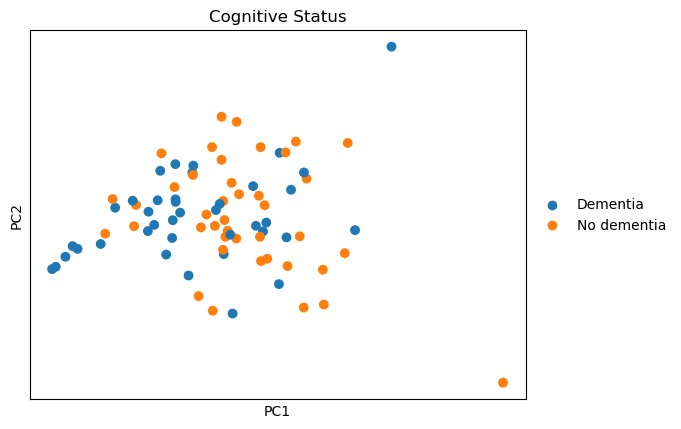

In [15]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = 'Cognitive Status', size = 200)

In [16]:
stat_res = DeseqStats(dds, contrast= ("Cognitive Status",  'Dementia', 'No dementia'))
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Cognitive Status Dementia vs No dementia
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
MIR1302-2HG     3.474480       -0.496470  0.223670 -2.219650  0.026443   
AL627309.1    590.740277        0.367545  0.139233  2.639785  0.008296   
AL627309.3     20.388466        0.182649  0.164748  1.108651  0.267581   
AL627309.5   1260.890330        0.161511  0.110002  1.468255  0.142035   
AL627309.4      5.405381       -1.072764  0.331736 -3.233785  0.001222   
...                  ...             ...       ...       ...       ...   
AC004556.3     45.673368       -0.518885  0.252765 -2.052836  0.040089   
AC023491.2      3.714849        0.260868  0.226990  1.149250  0.250453   
AC007325.1      3.041757       -0.117105  0.218173 -0.536753  0.591438   
AC007325.4    564.396832        0.289862  0.119052  2.434750  0.014902   
AC007325.2     23.975386       -0.103867  0.125504 -0.827604  0.407895   

                 padj  
MIR1302-

... done in 1.06 seconds.



In [17]:
res = stat_res.results_df

<h3> Rank by P-val </h3>

In [19]:
import gseapy as gp
res['minus_log_p'] = -np.log(res['pvalue'])
# Create a ranked list based on log2FoldChange (or any other metric)
ranked_genes = res['minus_log_p'].sort_values(ascending=False)


In [ ]:
res.to_csv("seattle_ad_deseq2_results_A9.csv")

In [21]:
# Run fGSEA using gseapy
gsea_results = gp.prerank(
    rnk=ranked_genes,
    gene_sets=['KEGG_2021_Human'],  # You can use predefined gene sets or your own
    min_size=10,  # Minimum size of gene sets to consider
    max_size=500,  # Maximum size of gene sets to consider
    n_jobs=4,  # Number of parallel jobs
)


In [22]:
out = []

for term in list(gsea_results.results):
    out.append([term,
               gsea_results.results[term]['fdr'],
               gsea_results.results[term]['es'],
               gsea_results.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df.head(20)

,Term,fdr,es,nes
0,KEGG_2021_Human__Collecting duct acid secretion,0.014962,0.683736,1.650284
1,KEGG_2021_Human__Endometrial cancer,0.188019,0.546907,1.394335
2,KEGG_2021_Human__Cocaine addiction,0.216839,0.505728,1.263904
3,KEGG_2021_Human__MicroRNAs in cancer,0.220037,0.525385,1.395703
4,KEGG_2021_Human__Type II diabetes mellitus,0.220249,0.506622,1.265087
5,KEGG_2021_Human__Non-small cell lung cancer,0.222559,0.492180,1.266499
6,KEGG_2021_Human__Hepatocellular carcinoma,0.226317,0.476341,1.270014
7,KEGG_2021_Human__Apoptosis,0.226700,0.482660,1.280143
8,KEGG_2021_Human__Morphine addiction,0.228083,0.501262,1.303164
9,KEGG_2021_Human__Chemokine signaling pathway,0.229288,0.479979,1.282087


<h3>Rank by lfc </h3>

In [24]:
# Create a ranked list based on log2FoldChange (or any other metric)
ranked_genes_lfc = res['log2FoldChange'].sort_values(ascending=False)

In [25]:
# Run fGSEA using gseapy
gsea_results_lfc = gp.prerank(
    rnk=ranked_genes_lfc,
    gene_sets=['KEGG_2021_Human'],  # You can use predefined gene sets or your own
    min_size=10,  # Minimum size of gene sets to consider
    max_size=500,  # Maximum size of gene sets to consider
    n_jobs=4,  # Number of parallel jobs
)


In [26]:
out = []

for term in list(gsea_results_lfc.results):
    out.append([term,
               gsea_results_lfc.results[term]['fdr'],
               gsea_results_lfc.results[term]['es'],
               gsea_results_lfc.results[term]['nes']])

out_df_lfc = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df_lfc.head(20)

,Term,fdr,es,nes
0,KEGG_2021_Human__Aldosterone-regulated sodium ...,0.000000,0.630450,2.280901
1,KEGG_2021_Human__Glutamatergic synapse,0.000000,0.528996,2.264004
2,KEGG_2021_Human__Fc gamma R-mediated phagocytosis,0.000000,0.530056,2.298556
3,KEGG_2021_Human__MAPK signaling pathway,0.000000,0.457693,2.294923
4,KEGG_2021_Human__Relaxin signaling pathway,0.000860,0.455597,2.034127
5,KEGG_2021_Human__Ras signaling pathway,0.000895,0.418860,2.039016
6,KEGG_2021_Human__Non-small cell lung cancer,0.000932,0.503352,2.052496
7,KEGG_2021_Human__TGF-beta signaling pathway,0.000973,0.482371,2.057762
8,KEGG_2021_Human__Endocrine and other factor-re...,0.000994,0.542549,2.071814
9,KEGG_2021_Human__ErbB signaling pathway,0.001017,0.497206,2.058694


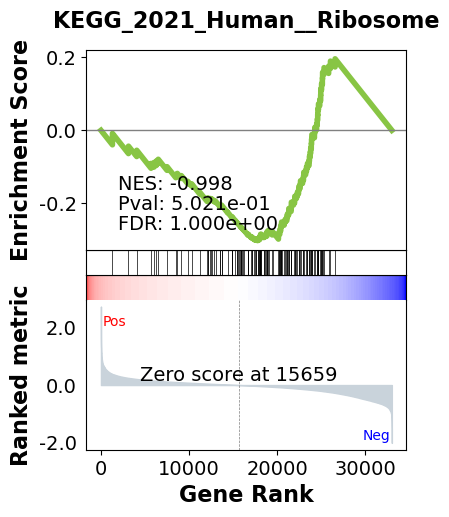

In [28]:
## easy way
terms = gsea_results_lfc.res2d.Term
axs = gsea_results_lfc.plot(terms="KEGG_2021_Human__Ribosome") # v1.0.5

What Ribo genes are in dataset?

In [29]:
import re
# Use a regular expression to search for genes matching the pattern in adata.var index
matching_genes = dds.var.index[dds.var.index.str.contains(r'^RP[SL].*', regex=True)].tolist()

# Display the matching genes
print(matching_genes)

['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34', 'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS6KA2-IT1', 'RPS6KA2-AS1', 'RPS20', 'RPL7', 'RPL30', 'RPL8', 'RPS6', 'RPL35', 'RPL12', 'RPL7A', 'RPS24', 'RPLP2', 'RPL27A', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS26', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPS29', 'RPL36AL', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPL4', 'RPLP1', 'RPS17', 'RPL3L', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23A', 'RPL23', 'RPL19', 'RPL27', 'RPS6KB1', 'RPL38', 'RPL17', 'RPS15', 'RPL36', 'RPS28', 'RPL18A', 'RPS16', 'RPS19', 'RPL18', 'RPL13A', 'RPS11', 'RPS9', 'RPL28', 'RPS5', 'RPS21', 'RPL3', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPL36A', 'RPL39', 'RPL10', 'RPS4Y1', 'RPS4Y2']


<h3>Plot Genes </h3>

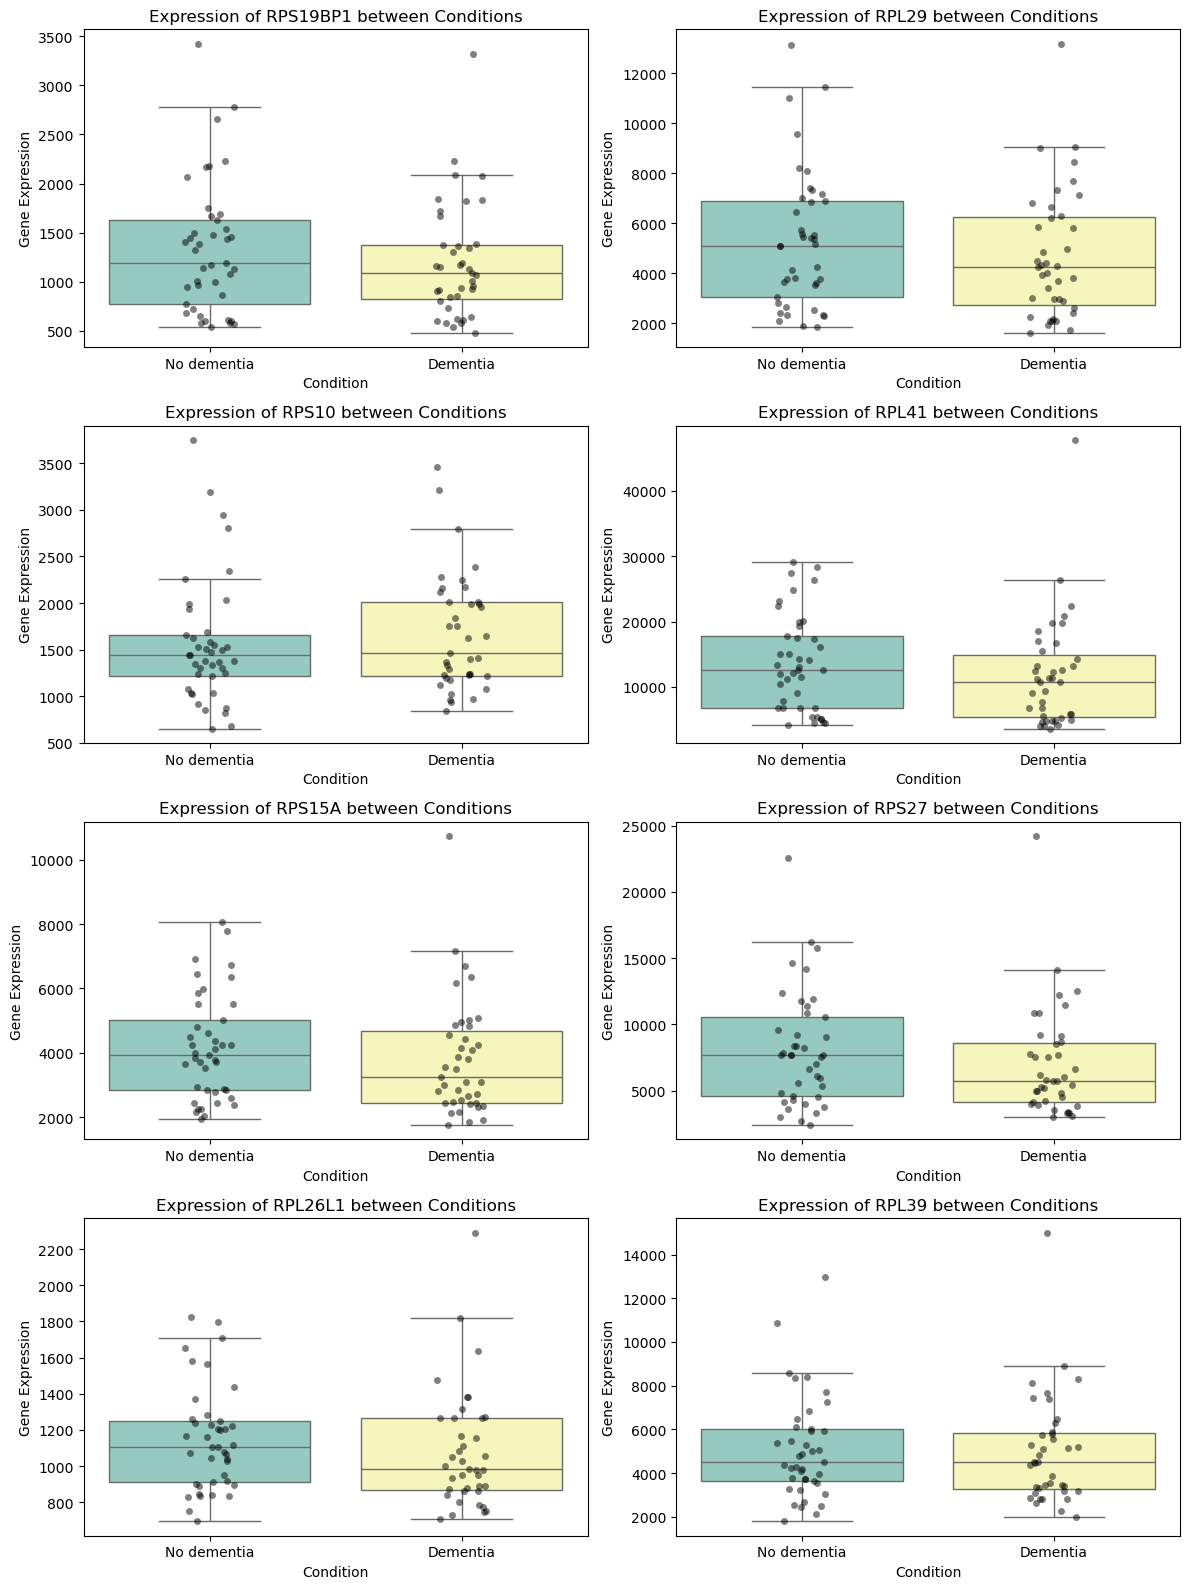

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

condition_1 = 'No dementia'
condition_2 = 'Dementia'

# Filter cells based on conditions of interest
condition1_cells = dds.obs[dds.obs['Cognitive Status'] == condition_1].index
condition2_cells = dds.obs[dds.obs['Cognitive Status'] == condition_2].index

# Specify the gene you want to plot
genes_of_interest = ['RPS19BP1', 'RPL29', 'RPS10', 'RPL41', "RPS15A", "RPS27", "RPL26L1", "RPL39"] 

# Create a 4x2 grid of plots for the genes
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

# Create a loop to plot each gene
# plt.figure(figsize=(10, 8))
for idx, gene_of_interest in enumerate(genes_of_interest):
    # plt.subplot(len(genes_of_interest), 1, idx + 1)
    
    # Extract gene expression for the current gene and conditions
    gene_expr_condition1 = dds[condition1_cells].layers["normed_counts"][:, dds.var_names == gene_of_interest].toarray().flatten()
    gene_expr_condition2 = dds[condition2_cells].layers["normed_counts"][:, dds.var_names == gene_of_interest].toarray().flatten()
    
    # Create a box-and-whisker plot for the current gene
    sns.boxplot(data=[gene_expr_condition1, gene_expr_condition2], palette="Set3", ax=axes[idx], fliersize = 0)
    sns.stripplot(data=[gene_expr_condition1, gene_expr_condition2], jitter=True, color='black', alpha=0.5, ax=axes[idx])
    axes[idx].set_xlabel('Condition')
    axes[idx].set_ylabel('Gene Expression')
    axes[idx].set_title(f'Expression of {gene_of_interest} between Conditions')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels([condition_1,condition_2])

plt.tight_layout()
plt.show()